| [06_text_generation/01_字符级人名生成.ipynb](https://github.com/shibing624/nlp-tutorial/tree/main/06_text_generation/01_字符级人名生成.ipynb)  | 从头训练Char-RNN做人名生成  |[Open In Colab](https://colab.research.google.com/github/shibing624/nlp-tutorial/blob/main/06_text_generation/01_字符级人名生成.ipynb) |


# 基与字符级RNN（Char-RNN）的人名生成

**作者**: [Sean Robertson](https://github.com/spro/practical-pytorch)

在上一个教程 [姓名识别国籍](https://github.com/shibing624/nlp-tutorial/blob/main/04_text_classification/04_%E5%BA%94%E7%94%A8_%E5%A7%93%E5%90%8D%E8%AF%86%E5%88%AB%E5%9B%BD%E7%B1%8D.ipynb)
里我们使用RNN把名字分类到它所属的语言中, 这次我们改变一下来学习从语言中生成名字. 

::

    > python sample.py Russian RUS
    Rovakov
    Uantov
    Shavakov

    > python sample.py German GER
    Gerren
    Ereng
    Rosher

    > python sample.py Spanish SPA
    Salla
    Parer
    Allan

    > python sample.py Chinese CHI
    Chan
    Hang
    Iun

我们仍然手工搭建一个包含几个线性层的小的RNN. 这次的最大的不同是输入一个类别, 每次输出一个字母, 
而不是读入所有名字的字母来预测一个类别. 循环的预测每一个字母来构成语言（也可以用文
字或者其他更高级的结构完成）, 通常被称为“语言模型”. 

**推荐阅读: **

假设你至少安装了PyTorch, 熟悉Python, 理解Tensors: 

-  http://pytorch.org/ : 安装说明
-  :doc:`/beginner/deep_learning_60min_blitz` 获取一般的 PyTorch 入门
-  :doc:`/beginner/pytorch_with_examples` 广泛且深入的概述
-  :doc:`/beginner/former_torchies_tutorial` 如果曾经是 Lua Torch 的用户

下面这些对了解 RNNs 和其工作原理也是很有用的: 

-  `The Unreasonable Effectiveness of Recurrent Neural
   Networks <http://karpathy.github.io/2015/05/21/rnn-effectiveness/>`
   展示了一系列真实生活中的例子
-  `Understanding LSTM
   Networks <http://colah.github.io/posts/2015-08-Understanding-LSTMs/>`
   是一篇特别关于LSTMs的文章, 但是对于一般的RNNs也很有益的



## 数据准备


从 `这里 <https://download.pytorch.org/tutorial/data.zip>`下载数据, 并解压到当前目录. (本教程已经下载过了)

更多的细节参考上一个教程, 总之, 数据含有一批纯文本文件:  ``data/names/[Language].txt`` 
每一行一个人名. 将行分割成数组, 并把 Unicode 转换成 ASCII 编码, 最后放进一个字典里 ``{language: [names ...]}``. 

In [2]:
import os
from io import open
import glob
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # 添加 EOS 标记

def findFiles(path): return glob.glob(path)

# 将 Unicode 字符串转换为纯 ASCII 编码, 感谢 http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# 读取文件并分割成行
def readLines(filename):
    with open(filename, encoding='utf-8') as f:
        return [unicodeToAscii(line.strip()) for line in f]

# 构建映射字典 category_lines , 每个类别是由很多个行组成的list
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish']
O'Neal


## 创建网络

这个网络扩展了RNN网络, 为类别张量添加了一个额外的参数, 并和其他的参数串联在一起. 类别张量
和字母的输入一样是 one-hot 向量. 

我们将输出解释成为下一个字母的概率, 采样的时候, 最有可能的输出被当做下一个输入. 

为了让网络更加有效工作, 我添加了第二个线性层 ``o2o`` （在合并了隐藏层和输出层的后面）. 
还有一个 Dropout 层,`使输入的部分值以给定的概率值随机的变成0` [dropout paper](https://arxiv.org/abs/1207.0580) 
（这里概率取0.1）, 这样做通常是为了模糊输入以防止过拟合. 这里我们在网络的最末端使用它, 从而故意添加一些混乱和增加采样的多样化. 

![net](https://i.imgur.com/Z2xbySO.png)


In [3]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

## 训练

### 训练前的准备

首先, 利用辅助函数产生随机的（category, line）对: 




In [4]:
import random

# 从list中随机选取项
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# 获取随机的类别和该类别中随机的行
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

对每一个时间点（也就是说在训练集中词的每个字母）网络的输入是 ``(类别, 当前字母, 隐藏层状态)`` , 
输出是 ``(下一个字母, 下一个隐藏层状态)`` . 对于每一个训练集, 我们需要的是类别、输入的字母集、输出/目标字母集. 

因为在每一步, 我们从当前的字母预测下一个字母, 这样的字母对是在原有行中连续字母的集合, 
例如, 对于 ``"ABCD<EOS>"`` 将会产生 ("A", "B"), ("B", "C"),
("C", "D"), ("D", "EOS"). 

![](https://i.imgur.com/JH58tXY.png)

类别张量是一个大小为 ``<1 x n_categories>`` 的 [one-hot tensor](https://en.wikipedia.org/wiki/One-hot) 张量, 
在训练的每一个时间点把它喂给网络 —— 这是一个设计的选择, 它可以被当作为初始隐藏状或其他策略的一部分. 




In [5]:
# 类别的 one-hot 向量
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# 输入串从第一个字母到最后一个字母（不包括 EOS ）的 one-hot 矩阵
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# 目标的第二个字母到结尾（EOS）的 LongTensor 
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

为了训练过程的便利, 添加一个 ``randomTrainingExample`` 函数, 获取随机的 (category, line) 对, 
并把他们转换成需要的 (category, input, target) 张量. 




In [6]:
# 从随机的（category, line）对中生成 category, input, and target 张量 
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

### 网络的训练


与分类相比, 分类只用到了最后的输出, 而这里每个步都会产生一个预测, 所以我们需要计算每一步的损失. 

自动求导（autograd）的魔力就在于, 它允许将每一步的损失简单的加和, 并在最后调用 backward 




In [7]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

为了跟踪训练花费了多长时间, 这里添加一个 ``timeSince(timestamp)`` 函数, 返回一个人们易读的字符串: 




In [8]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

训练和往常一样, 不停的调用 train 并等待一会, 打印当前时间, 每隔 ``print_every`` 
个例子打印 loss, 将每 ``plot_every`` 个例子的平均损失保存在 ``all_losses`` 中以便后面画图. 




In [9]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 8s (5000 5%) 2.3679
0m 16s (10000 10%) 2.3266
0m 25s (15000 15%) 2.3716
0m 34s (20000 20%) 1.8878
0m 42s (25000 25%) 3.0048
0m 50s (30000 30%) 2.5958
0m 58s (35000 35%) 2.6039
1m 7s (40000 40%) 3.3688
1m 16s (45000 45%) 2.6047
1m 25s (50000 50%) 2.8957
1m 34s (55000 55%) 2.0515
1m 42s (60000 60%) 2.3317
1m 51s (65000 65%) 2.9110
2m 0s (70000 70%) 2.5003
2m 9s (75000 75%) 2.2145
2m 19s (80000 80%) 2.4460
2m 28s (85000 85%) 2.1489
2m 36s (90000 90%) 2.7495
2m 46s (95000 95%) 2.7960
2m 55s (100000 100%) 2.0868


### 绘制损失


从 all\_losses 中绘制历史损失, 以展现网络的学习过程




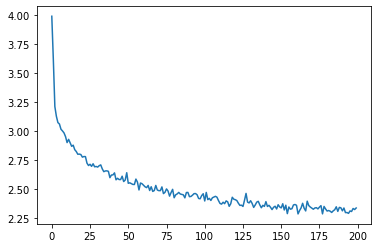

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

## 网络采样


为了采样, 我们给网络一个字母并问下一个字母是什么, 重复这个过程直到 EOS 标记. 

-  创建输入类别、起始字母和隐藏层状态的张量
-  创建一个带有起始字母的 ``output_name`` 串
-  直到最大的输出长度, 

   -  当前字母喂给网络
   -  从最高的输出获取下一个字母和下一个隐藏层状态
   -  如果输出字母是 EOS, 算法结束
   -  如果输出是常规字母, 将其加入到 ``output_name`` 并继续

-  返回最终的名字

Note:

与给定起始字母不同的是, 有其他的策略是在训练的时候包含一个“串起始”标记, 让网络选择属于自己的起始字母. 




In [11]:
max_length = 20

# 从类别和起始字母采样
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name
    
# 给定一个类别和多个起始字母 获取个采样结果
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Rovakov
Uantov
Shantan
Gangent
Eren
Roure
Santaraz
Pares
Allan
Chan
Han
Iun


练习
=========

-  尝试使用不同 类别->行 数据集, 例如: 

   -  小说系列 -> 角色名字
   -  词性 -> 词语
   -  国家 -> 城市

-  使用“串起始”标记, 使采样的时候不用给定起始字母
-  使用更大和/或更好的网络结构获取更好的结果

   -  尝试一下 nn.LSTM 和 nn.GRU 层
   -  将这些 RNNs 组合成更高级的网络




本节完。